# Grad-CAM

## Computing saliency masks for Grad-CAM

Let's use the PAIR saliency library to compute XRAI feature attributions. You need to have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency tensorflow
```

In [6]:
# !pip install saliency tensorflow

In [1]:
# imports
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P

import saliency.core as saliency

%matplotlib inline

In [2]:
print(f'Tensorflow verseion: {tf.__version__}')

Tensorflow verseion: 2.4.0


### Utility methods from the saliency example notebook

In [11]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path, model='VGG'):
    im = PIL.Image.open(file_path)
    if model == 'Inception':
        im = im.resize((299,299))
    else: 
        im = im.resize((224,224))
    im = np.asarray(im)
    return im

def PreprocessVGGImage(im):
    im = tf.keras.applications.vgg16.preprocess_input(im)
    return im

def PreprocessInceptionImage(im):
    im = tf.keras.applications.inception_v3.preprocess_input(im)
    return im

### Loading the VGG16 model for ImageNet

In [25]:
vgg16 = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', include_top=True)
conv_layer = m.get_layer('block5_conv3')
model = tf.keras.models.Model(
    [m.inputs], [conv_layer.output, m.output])

`call_model_function` is how we pass inputs to our model and receive outputs necessary to compute saliency masks. The description of this method and necessary outputs is in the base CoreSaliency description, as well as separately for each method.

In [27]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

### Load an image and infer

Prediction class: 89


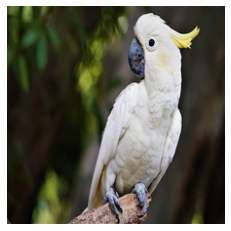

In [28]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg')
im = PreprocessVGGImage(im_orig)

# Show the image
ShowImage(im_orig)

_, predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  

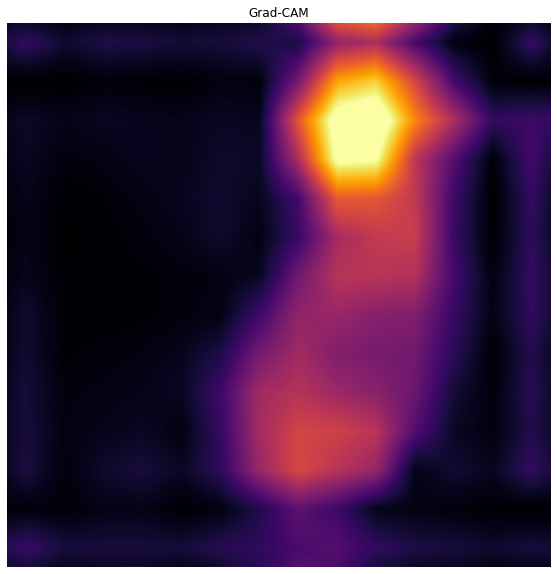

In [31]:
# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(grad_cam_mask_grayscale, title='Grad-CAM', ax=P.subplot(ROWS, COLS, 1))

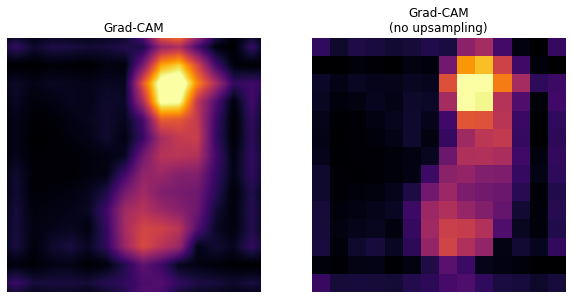

In [30]:
# Compare Grad-CAM and un-smoothed Grad-CAM.

# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
grad_cam_mask_3d_noresize = grad_cam.GetMask(im, call_model_function, call_model_args, should_resize=False)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
grad_cam_mask_grayscale_noresize = saliency.VisualizeImageGrayscale(grad_cam_mask_3d_noresize)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(grad_cam_mask_grayscale, title='Grad-CAM', ax=P.subplot(ROWS, COLS, 1))
ShowHeatMap(grad_cam_mask_grayscale_noresize, title='Grad-CAM\n(no upsampling)', ax=P.subplot(ROWS, COLS, 2))

### Use Grad-CAM with an Inception model

In [22]:
m = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=True)
conv_layer = m.layers[-5]
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

Prediction class: 89


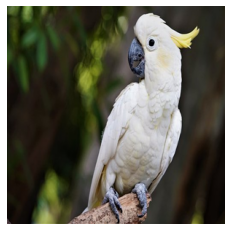

In [23]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg', model='Inception')
im = PreprocessInceptionImage(im_orig)

# Show the image
ShowImage(im_orig)

_, predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  

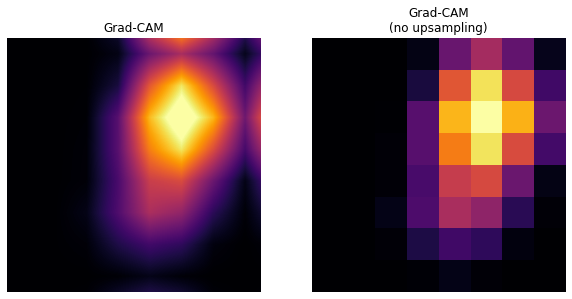

In [24]:
# Compare Grad-CAM and Smoothgrad with Grad-CAM.

# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
grad_cam_mask_3d_noresize = grad_cam.GetMask(im, call_model_function, call_model_args, should_resize=False)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
grad_cam_mask_grayscale_noresize = saliency.VisualizeImageGrayscale(grad_cam_mask_3d_noresize)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(grad_cam_mask_grayscale, title='Grad-CAM', ax=P.subplot(ROWS, COLS, 1))
ShowHeatMap(grad_cam_mask_grayscale_noresize, title='Grad-CAM\n(no upsampling)', ax=P.subplot(ROWS, COLS, 2))

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License